In [40]:
! pip install --quiet gensim

In [53]:
import pandas as pd
import re
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np

yelps = pd.read_csv('yelps.csv').sample(frac = 1).reset_index(drop = True)

In [42]:
from bs4 import BeautifulSoup

def clean_yelp(s):
    s = BeautifulSoup(s, 'html5lib').get_text()
    s = ' '.join(s.split())
    s = s.strip().lower()
    return s

def tokenize(s):
    """ Returns a list of strings (tokens) from the document """
    pat = re.compile(r"(?u)\b\w\w+\b")
    strs = pat.findall(s)
    
    return strs

In [43]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD

# Create a count vectorizer, using the preprocessor and tokenizer from above
# use TruncatedSVD from Sklearn to generate a term embedding matrix for your data
# that is 100 dimensional in size.
# Embed your documents via that term embedding matrix (this is just the PCA of the 
# TF matrix, as returned by "transform" on TruncatedSVD

# Here you should have TWO vector representations of your Yelp data: 
# 1. The original TF matrix
# 2. The first 100 components of the PCA of that matrix, as performed by TruncatedSVD


count_vectorizer = CountVectorizer(preprocessor = clean_yelp,
                                   tokenizer = tokenize)
TF_matrix = count_vectorizer.fit_transform(yelps.text)




# Get PCA
SVD_trun = TruncatedSVD(n_components = 100)
PCA_matrix = SVD_trun.fit_transform(TF_matrix)




In [44]:
from sklearn.metrics import accuracy_score

def test_holdout_vectors(V, y, cutoff):
    model = LogisticRegression()
    model.fit(V[:cutoff], y[:cutoff])
    preds = model.predict(V[cutoff:])
    return accuracy_score(preds, y[cutoff:])

In [45]:
# Test your vector representations using the above function, test_holdout_vectors. 
# for several levels of "cutoff". 

# This function simulates training on a small part of your data and testing on the rest.
# Thus, it's as though you have some labelled data but a bunch of unlabelled data. 
# This is essentially a semi-supervised situation. 

# Do the word embeddings generated via SVD allow you to pull information from the 
# unlabeled data and improve your score given a small training set? 


cut_offs = [50, 100, 250, 500, 1000, 2500, 5000, 10000, 20000, 40000, 75000]

results_TF = []
results_SVD = []

for cut_off in cut_offs:
    
    TF = test_holdout_vectors(TF_matrix ,
                              yelps.positive,
                              cut_off)
    SVD = test_holdout_vectors(PCA_matrix,
                               yelps.positive,
                               cut_off)
    
    results_TF.append(TF)
    results_SVD.append(SVD)
    


    
    
    

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Defau

In [46]:
results_SVD

[0.7151675837918959,
 0.7913513513513514,
 0.845203007518797,
 0.8545628140703517,
 0.8666060606060606,
 0.8847589743589743,
 0.8894421052631579,
 0.8938222222222222,
 0.895875,
 0.8959333333333334,
 0.89308]

Text(0, 0.5, 'Accuracy')

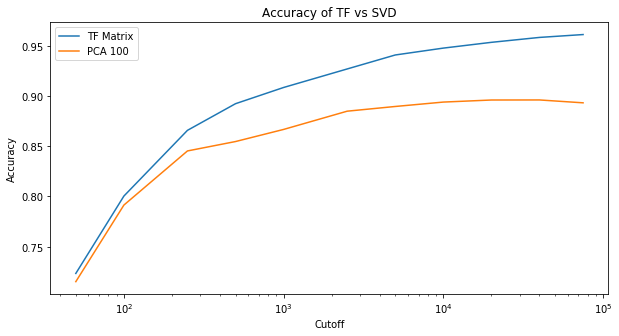

In [57]:
# Investigate the effect of the cutoff
plt.figure(figsize=(10,5))
plt.plot(cut_offs, results_TF)
plt.plot(cut_offs, results_SVD)
plt.legend(['TF Matrix', 'PCA 100'])
plt.xscale("log")
plt.title("Accuracy of TF vs SVD")
plt.xlabel("Cutoff")
plt.ylabel("Accuracy")





SVD can't seem to perform as well as the TF matrix, especially as the training data size increases!

In [65]:
from gensim.models import Word2Vec

# Next, create another term embedding via Word2Vec, also 100 dimensional
# Look at the documentation from the library gensim and see what hyperparameters
# you can choose to tune. 
# Note: training takes time, so you probably won't want to try too many!

# pass the cleaned and tokenized yelp reviews as "sentences" to your model
# to build the vocabulary and train the word vectors. 



sentences = yelps.text.apply(clean_yelp).apply(tokenize)
model = Word2Vec(sentences, window = 4, min_count=4, workers=4)

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:273: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://www.consumeraffairs.com/news/mypillow-gets-a-rude-awakening-as-the-better-business-bureau-gives-it-an-f-010517.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [66]:
# use the embed_w2v function to embed your Yelp reviews using the new
# word2vec word embeddings. Each review will be a normalized sum of the
# words that it is made of. 
# See how this improves the scores in the classification task using
# test_holdout_vectors -- is word2vec better? At what training-set sizes does it help
# more? 

word2vec_matrix = np.array([embed_w2v(t, model) for t in sentences])

word2vec_results = []

for cuts in cut_offs:
    
    word2vec = test_holdout_vectors(word2vec_matrix, yelps.positive, cuts)
    word2vec_results.append(word2vec)

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Defau

In [67]:
word2vec_results

[0.8085742871435718,
 0.8349149149149149,
 0.8562907268170427,
 0.889286432160804,
 0.9107070707070707,
 0.9254051282051282,
 0.9335157894736842,
 0.9388333333333333,
 0.941825,
 0.9434666666666667,
 0.9436]

Text(0, 0.5, 'Accuracy')

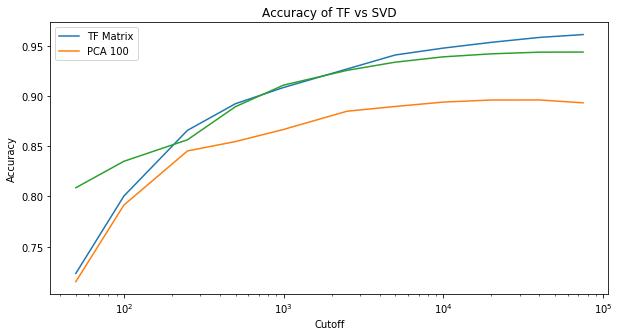

In [68]:
plt.figure(figsize=(10,5))
plt.plot(cut_offs, results_TF)
plt.plot(cut_offs, results_SVD)
plt.plot(cut_offs, word2vec_results)

plt.legend(['TF Matrix', 'PCA 100'])
plt.xscale("log")
plt.title("Accuracy of TF vs SVD")
plt.xlabel("Cutoff")
plt.ylabel("Accuracy")

In [60]:
import numpy as np

def embed_w2v(tokens, w2v):
    idxs = [w2v.wv.vocab.get(t) for t in tokens]
    idxs = [t.index for t in idxs if t]
    N = w2v.wv.vectors.shape[1]
    if len(idxs) < 1:
        return np.zeros(N)
    a = np.sum(w2v.wv.vectors[idxs, :], axis=0)
    a /= np.linalg.norm(a)
    return a


# use as follows: np.array([embed_w2v(t, w2v) for t in X])

In [69]:
import pandas as pd
import re
from functools import reduce

pats = [re.compile(r'https?:\/\/[^\s]+'), 
        re.compile(r'rt\s*@\w+\s?:?'),
        re.compile(r'@\w+')]

def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')


def clean_twitter(s):
    """ Cleans Twitter specific issues
    
    Should probably clean out mentions, URLs, and RT's.
    """
    s = s.lower()
    
    # Mentions (@), RTs and https removed
    s = re.sub(r"([@#&]\w+)|https\S+|RT|:|;|\n|@", '', s)
    s = deEmojify(s)
    return s


In [70]:
# Load tweet!
# NOTE: this file needs to be downloaded from Box! 

with open('tweets.txt') as f:
    tweets = pd.Series(f.readlines())

In [71]:
# Now embed this twitter data, again using Word2Vec and LSA (SVD)
# you don't have any labels, but you might be able to 
# find some interesting phenomena. 

# Explore using either or both of the following tools: 
# 1. Word2Vec has a built in feature for getting most similar
# words, including via positive/negative examples (subtraction)
# What happens when you subtract "hillary" from "trump"? 
# 
# Bonus: build a similar feature for your LSA features and
# see if you can do similar vector math

# 2. Use the visualize_dist function to see how
# the tweet-tweet distance looks for a selection
# of random tweets. Do you agree with the distance? 
# Does one embedding seem better than another? 


# word2vec embed
tweet_vectorizer = CountVectorizer(preprocessor = clean_twitter, 
                                   tokenizer = tokenize) 
TF_tweet = count_vectorizer.fit_transform(tweets)

# SVD embed
SVD_trun = TruncatedSVD(n_components=100)  
tweet_SVD = SVD_trun.fit_transform(TF_tweet)

# Word2Vec embed
sentencesTweets = [tokenize(clean_twitter(i)) for i in tweets]
model2 = Word2Vec(sentencesTweets, workers=4)







/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/n1XwCJhPR8
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/aubb187Ci9
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/6agqVSHv9z
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/ySm6k6gQ3I
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/W2f7RJDd8i
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/4Y45xhKrQW
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that 

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/iDSci4Aq1f
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/HQxUqg46aB
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/gCB35BGpcf
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that 

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/L5F7G7R7mI
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/4TkMJtsX2t
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/afKQBqIQaA
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that do

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/ZgEAHHWE6O
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/BPSHfMbJw1
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/bBswavVGrO
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/CJH8DS0lQo
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/kvFfzTgwP6
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/fwd3fVOHU4
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/vXuDDAubaS
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/DdPsebiH9u
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/xBVJvIQbV5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/VAEePHefs0
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/XjrVAcTe9L
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/4EXxRsnQfd
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/aSPh0KUebW
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/qMZ1aP1ue9
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/rHQTxODcqA
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that 

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/r14BsteXLb
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/jRBZ79P8fi
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/qnOaaEUyrr
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that 

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/lAmtVxeN3w
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/SGKyo8PF9W
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/u246PGh9wN
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that do

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/yZRn7WjX9n
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/yQjehOgECy
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/VkQDJPSxZh
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/xeOvzkscXb
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/nMXjNV2sap
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/M24l2yHxmr
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/gtgu08oP1N
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/j8HDGFyw5Q
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/OaYUrdl9M9
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/pGzFhF6WQ1
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/8uuA132UVb
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/vrx4dRTaYU
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/uA63eGozZl
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/wJEHoCTsd3
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/kY4UtdNtem
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/YGo68baP4B
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/xKsLEwVK3B
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/YJ1DNqGfXL
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/RR3dN0U4Mw
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/J5j7ur3TwT
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/x5yHMtexGv
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/PsnSZ4PNJT
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/y5P8jbFKSY
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/C5zudOfKm1
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/rJjWs87Zuo
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/bnj4qL28hT
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/JmhfSOJDM2
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/o6CqYqDGug
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/fRGaBef97t
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/i5Jddl7Pqr
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/0Xa8efROTw
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/z0N8agKOuv
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/qBRobtLTku
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/2wwNMawjgz
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/FdRXRbB2F4
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/EjWaRwTzH1
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/y7EV0ftEQ2
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/YLCbNHSRZE
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/XfJgqbI2Hh
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/r8YtdjVczS
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/kfpmSRU8Z3
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/OL94FXhMLW
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/bUjMyTbmrv
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/fiNXpO4MzZ
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/CC5hyp6upL
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/jft6t6OqgX
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/fzj7RViWY5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/nKER9HScYC
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that 

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/CfCCXZqcYm
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/lGZBXV816F
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/kWrDI0oTYK
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/mUbXSweAQi
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/WJMFRKCEpy
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/ajED5s7Xtc
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/ZFPHn52Can
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/bFVCnkmDoy
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/JoM3q1Mxsv
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/IxyWziM09F
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/OXsn6hL3KF
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/JaegJFNo7p
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/MNPrc1jzrd
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/nXI8owcj4F
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/woV8oIhW7r
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/4mVonQzhcW
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/1KxlDvFAMO
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/0dKErDqtSO
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/G9SGoB9ip5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/fMUkgn2ZlM
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/JInXjD9lzQ
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/2fEASYXTHT
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/JXLkP4SdMl
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/S4mFqRAxU5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/ZXzTz3Z4cY
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/aa1zu8EooQ
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/ZdGgjVe5OW
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/ALxQt5IRqG
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/Yk3mt1WJCf
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/FV8lGbSnq3
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/I4b87S7BRp
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/PlxA9Pp4Bb
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/PyRiR8cozv
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/IseDBfReN9
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/2j58p5grSJ
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/PQlqFF3aCz
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/8WlGZ61RLt
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/1pUU3GARHI
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/PGNAv0zb4S
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/Qxx7WzTMg7
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/o9yeQ27aMc
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/dHpDXUQKh4
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/x5HEYexnj3
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/zRKmUG9EUQ
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/cB9G0H58XV.
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/ZHi15xol8s
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/e89SbgvqY0
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/fRlBHH93bq
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that 

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/TONMZQJjBj
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/xn2hYcxwPT
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/XwdE5AlM0q
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/I7Q3CdASJX
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/CXJwm8DrGk
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/S6JTAHcQCi
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/Re8bxc63v5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/PLOXarZmp2
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/YkRHtfAvts
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/ERHa13RG7m
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/rvre3QOJP1
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/ljsxEIHVLv
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/I5oizZZGpz
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/X4zoSI6NBX
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/bGpF1dJWVl
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/OzaBgqU3ur
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/GaqFeg1R7J
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/shIKe19gWB
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/63CDGx4RwT
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/k80PwjBT8w
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/js37VCwNoS
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/dwM0lH6dci
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/MrZbRG31b8
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/51mKQTZ2hu
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/LtWbejXxpz
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/xqjBQ2V0Q1
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/ixJU8T4sHA
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/iqE47H7XRi
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/ow3CTY7s34
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/LSDs8RtVQu
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/9EPeNHQk6b
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/mNtW2xRLap
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/lP0iKMrU0F
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/AxQGD0vVOc
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/CU9JfStVj9
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/qNGbemkxj7
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that do

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/SkDDEtooUq
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/1LYURU14fq
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/YGJlGhmgQm
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/topUOX2dKj
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/lVibJpPJng
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/DSRZNKelHq
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/LqhaNEXY4v
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/jlauIkxdnC
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/1wu4CzXVna
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/fjRBA8hbLb
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/xXeDJsUH77
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/QOeDM32FWy
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that 

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/RkHj5ctd1s
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/HCWq39DV0P
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/fBF8oTkp97
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/ZYcWEBfUTH
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/0amMAXehCp
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/9TBj0MSfUK
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/ht1y5SvviG
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/TcHpEtjZ9l
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/ESfaXPyYtb
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/tREYPgLPU9
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/hckkfTtbfd
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/cVFmH443aE
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/YsKi6ikpoT
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/NRHutOlVfc
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/akhZC7lpFw
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/bGYmEooXQa
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/jAY0fgklAl
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/VsNX8zhfi2
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/ijtcxpv1Ik
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/qePHd9E6ix
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/HJigkMKhtS
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/gBc9nnHCFD
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/vf0tJr6bcf
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/DlT1Ab58Ht
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/yhGa57zpVq
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/U21OFLe0Aq
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/gratagrgbN
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/yrhwOw0Unh
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/seCfV5E8YS
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/ab3C0iODQ4
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/Ox2fCv6vd1
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/WjRxnxa1YX
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/MpoqunOEUh
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/0vGGZIdNxP
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/BzJGqGOmTm
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/zoNB6qVMX4
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/bFkGNmFy0A
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/yhb4h6CUOa
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/bH8mg646qC
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/pxtWB3AL7M
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/BU1KFg7EaM
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/hr0Wx85Oha
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/kpjsJAca9n
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/jeE5dDRvzP
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/V4te654J8D
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that 

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/dzJdw2M7xv
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/x5DoVM0HrE
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/iIDcnqWXtg
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that d

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/4U5l9igVby
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/P34riaAG81
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/f4MRYJvuPf
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that 

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/vCKpWkxCOp
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/wDNmHo0RIY
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/hM2KlnysO9
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/2sIlLICuUw
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/kINfSSWm3r
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/lb2psChrmw
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/J8ggsvlTET
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/G2hwAqYueG
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/qX3SXTyWmh
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/t3Vd59MXEi
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/VCArrTirA7
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/xFulA1nUUV
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/yNqk6PPMB5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/GRy8br5FNJ
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/C5xMsGv4oi
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/FQrHUbZQJV
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/XzdhdbvF0X
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/IF5Ktn7dPs
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/nzTWMfG3dC
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/l4yWtI4Wml
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/86f2gLEGoz
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/dsuFhJ4nQQ
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/lpbIJQPSrS
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/yfqAvCgjMc
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/csXZ3P4OW1
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/LxarhnKKae
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/4r24hkMxsi
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/JTOvrFyDKJ
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/NrdXIacGKE
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/E52BG0ke4A
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/UNVqErw9HY
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/KxI8tdWfA9
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/pdmgKraiPO
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/TrUr7XREYC
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/jUjsivhxIn
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/F5MFa4qHQ5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/byLCU4KJj5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/kWr5MvFLL3
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/PyfbLi6Yd7
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/mMJ0Klnun9
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/FHIssWHzDC
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/3OfUu9SQzq
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/oNN7DW9Dwj
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/iKDXIkzbVd
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/EB8RgeqDnW
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that 

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/RjAayqSs5Q
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/vX1mD5EarL
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/lwGJvfbOfa
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/oBDnD1LX2i
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/XmKCzRF1ax
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/4Qb8PkVdmF
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/mhkqqIMRSu
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/e3FrK3TAU4
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/lAvVkySlnF
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/7KjUgatpGP
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/Rm4tDFzdMA
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/pBVFSmsNbT
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/6Jj9rTEIwj
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/EGS7VCdQk8
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/VoLVz31F63
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/4HiBVp50OR
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/MIekOFcitb
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/E1Ia713Jox
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/H2zXf8KnTn
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/hk3DssGe90
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/dsvjEmmM8r
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/0qeB5lPdoc
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/d1L3sWVIHZ
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/vlSREJnJwf
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/55TXVp0ITM
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/AeN8fTwg5A
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/G6LulqIHNm
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/3N5GQsJOo4
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/ok5hw0qoGi
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/aI2dSH9yj2
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/ZtRd2AENYk
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/2hm59099HW
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/AVj5ZIZFoG
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/JdFqGBpoif
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/Ctmjre4GI1
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/hhrFh34W8T
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/LfUw57eMYZ
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/A7cXt3lvb8
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/QSXqwURYvp
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/UgExLYod8C
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/WzvL0AIcuD
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/mh7caTdG0d
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that 

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/lwjSpbVJBM
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/bX9Lm6NrvP
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/4wVIeG6t2f
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that do

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/9waEPCN7dT
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/r2i6pmWfHR
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/3IVJr391KU
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/ZHr6Avn40P
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/2U7wvvkNUS
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/63uuZVmgxz
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/Uu6ez2jRAn
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/GjSN8tdkvN
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/MPkNiLa8PQ
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/oIAeU5ZBix
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/obnSf8MilO
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/q30qu1xIL5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/MFeIive1IQ
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/ZFvkuURkOH
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/4P4RoDZKme
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/BK9FFaVs3y
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/WC9zqpMd7A
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/9YeJe9DekC
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/n6xSmsRgGT
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/8TMwHtNmXM
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/XngwfMAGB4
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/uePPji5e41
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/Q9xHcraMvQ
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/WZ5HrbsarQ
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/Q5eIqoK66b
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/D0mHqH0UYf
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/2s192K9p2V
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/L5UByEmbJs
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/biY2LgBYkU
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/kDsI6TCfgT
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/bgnkkj9nlW
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/2Ic1ZoWCF7
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/zVp53zxVsy
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/OEyAc3M1c2
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/VBjz7DMQ2o
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/6JAWBFjwBQ
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that 

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/NWWgdqRW5R
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/Q7V1jyWqdz
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/MGL6vP5ULG
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that 

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/42zokIXYtW
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/pqhzO4A2hV
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/4heyFULXp3
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that d

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/sVjfPo76AV
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/xGEF17TI5o
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/e2bVR6lVvu
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/BvMlI9tHvD
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/u79nt8Yzoz
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/v6gS6Oi5Gg
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/ZTLzu0dyHx
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/bOxaeLQWrS
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/oJZYTtD2O1
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/KzHv1bmagX
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/nIC50K6exx
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/EDVhFSUAVo
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/VTvMzCyu3n
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/0yMRRNHjMv
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/1NESsGozff
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/t5mvmzekoO
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/i6eJEXp8Po
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/aCRS2KNIjH
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/X9aQ24FrtM
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/i8BVEXn9zV
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/1AKEpZuz4J
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/b2D8l7bhqQ
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/Zm5Ntrrfwa
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/lnjO7Td0dF
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/BLrfGhwrnk
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/dkOzDFs7Fp
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/isksgY4cEG
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that do

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/EGlRSfLqIu
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/UagGxbQbng
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/aRwoMJFJzE
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that 

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/uEQ4z4RcfC
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/CdN4aMVnvP
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/ZXdIUnopkm
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/XB74RxqPX7
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/5C55odEGUd
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/fKHQEC1QrS
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/3c7fP8XYCz
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/cjCq4e1vYZ
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/athdz1Ez9m
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/N1o44oIGUv
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/R1nVOd7XHC
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/EgVaCXPMnK
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/m1jIf53p1g
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/vsAx7An2wg
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/ZKbBEkIB25
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that do

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/3nlmmMBM4E
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/oYU5MBHsrF
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/hBi460zGjK
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/ncWJoUPXvc
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/DputUQyNJY
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/2wNtYXfdiT
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/Lp4t3ySe40
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/HuvgEs1nbT
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/CRSIUM1HTP
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/hO5i1W4AwZ
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/NpTL1CHDWl
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/Wgn3MnLvvV
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/7ehTvrRDSo
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/czudgxKz3K
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/MTgMkJVK4m
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/cKYr6tiMM2
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/Zo3y06V9mJ
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/2Swe4EMOkY
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that 

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/9RiWBDreRY
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/vvozR2TMbs
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/RNMUtBAo2I
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that 

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/uueKebzahR
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/km0o4gjeLW
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/CmecURDmpa
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/qffmLcOQ26
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/M8iOFDJpYh
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/bRPysQXVZ8
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/dERjwXBf83
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/G4Pb8PPudF
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/7T6iBKT7x7
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/OWWhxQNlNL
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/gD0cKGX1YJ
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/RU717syWN0
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/rEdNocWYIH
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/JUU7OZqtBs
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/4QgF9wr6XW
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/ECG1salwbY
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/MQBaMJ1iKl
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/T5wxIt5OyQ
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/hqv0KkatiZ
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/b7mD1IA8su
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/oD8SaTIFRF
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that 

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/6iywDjNFSW
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/5cDtP7BV8A
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/fXlH6itK6a
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that d

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/Z6Rn12F5Ap
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/Q820IcgUMA
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/19T4FFTYcx
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/VvnwfZ5Y62
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/lsglm5Wi35
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/oEOjehsvEt
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/RfLs8Bdpsd
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/1B9QQjGI9y
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/cw3iIePsWG
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that do

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/VJ3sB9Tczm
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/C6OYJ5ma8e
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/Skuepp5Jtc
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/NYEsvZlghv
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/4CUyKqUDbJ
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/lY4KXoOUgQ
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that d

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/qI9CFKcYjK
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/qenPELH8Bb
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/TC7Upc74Q9
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that 

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/goPHIoacO6
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/A5DGbae4p0
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/pYD4w5ndWB
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that 

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/X1TGo4MEb6
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/L2G4w0H7YX
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/iy67dZN0Or
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/MOoyDRJVEm
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/YPqebcPkoU
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/2OV0douNmq
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/dtInin6njg
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/befNuo4iWw
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/dbOkLkufMI
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that 

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/bFjllTXUZk
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/zWxeRAjNkJ
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/1R4IoOPj92
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/w69Zo49blC
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/L6Lh4DgWmV
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/UbK1NCuPt2
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/ps7HD2Oszx
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/tr10aM52BT
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/2DkYklMBXe
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/Q5ZD6EUkTW
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/POKXAqKunA
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/K3o8aNoizI
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that do

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/haMz1faSjx
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/18hmi3f8cT
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/pHTOoci0NK
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/tu1amI9wue
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/4PixdeHfIY
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/6zKfr20k7Q
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that 

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/f3z27pAyyQ
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/lxEs4DhMqI
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/eo5CJzRWel
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/xIWaqANB1E
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/5oiVYxRVrB
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/m2eFsgYWJw
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/Fbh75E7ORH
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/W8QDz5uEra
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/FB4pUFFVul
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/yq0EaxIALZ
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/ucPjg55dth
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/yC0j1Dqpfd
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that do

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/XALamAw5oc
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/y5K0ieKEu4
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/VMvUmqnu4K
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that 

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/0qsqzLIbkz
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/IBGCTkraK5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/11WKhWIVoq
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that 

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/Rq4hU3LKDZ
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/aboUAjO6W5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/fVeVTVUh9E
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that do

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/sTkQGxBpi6
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/TPvkECBPqI
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/fc9JabOwac
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that 

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/UY5CD88QQN
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/UieZVsFtka
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/ZZrZB30i3C
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/wiEkmeUcsK
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/f0JAMbruFK
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/sKjc7Etsmq
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/0A8TDEtCLZ
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/6fk63iMCea
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/1jcu2w1Rp9
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that 

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/OFPELrRSKY
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/Tqp2HXviab
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/EJIsf82bqu
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that do

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/gB8Eq4tuN6
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/pJHrTIvzdb
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/yrJYs4gz4x
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that do

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/YeR3XfwGNN
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/vcMLF5VbeZ
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/ksTyseMeDF
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that 

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/fCjtAyCy09
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/81nZwZ3js6
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/8K9wn4EuRM
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/hEwbdh2lg8
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/K6hq7fYHvx
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/m3sFhoEnjM
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that 

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/xALkb9hQAq
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/SkvMBPkQeK
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/T8f8My08zN
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that 

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/cB9G0H58XV
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/hvkZXKEINP
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/VPxnPmfIdv
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that 

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/SwM0Ufdk2Z
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/mJ1zEuFPuA
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/KHi4BwGQBb
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that do

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/Z7wjXTxa4s
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/870Gab7UfW
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/ZBZqKrhVxG
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/KS19ukZ0PF
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/AxXn5cSKxx
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/wnZX6hqUoW
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that 

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/JkNiTucbGl
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/8Tkz1vj9ry
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/kQCpNCGquR
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that 

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/bdkMFbKOn6
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/9HOusK9NjF
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/gMkhUx5aLh
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that do

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/4W27gxCmbU
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/kWjMofMxBm
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/TTNcHweeNv
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that 

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/SKjeWjDOyz
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/lKTL7oXvZQ
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/abHyoOTpTc
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that 

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/OLuOjs4WaX
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/a4DYfsLYKv
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/GJ3FaeoseJ
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that 

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/5hJOV1KX7m
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/6xrgn4XtlN
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/IWZusXSs82
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that d

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/eGedkfMw6O
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/gwf47tgGpx
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/HDx81k5r1l
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/uQkNCEQvSj
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/3Y5X2bJqSl
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/R2e4OGHKJq
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that 

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/fNGgWy8SGs
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/uXTuyJZfDV
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/KJJSXslmIe
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/72cHiMbGCj
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/RVRvmA796f
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/z1vEqzBkN3
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that 

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/TDwFOedmJ6
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/77NtKSWH82
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/RCUbzRf0Cx
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that 

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/pYq0CeOpRg
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/bO4pac4PHp
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/GLRZvAc5xl
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that 

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/IHfSxOWGQX
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/PqPLNnXaGH
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/hs5fHlhEQD
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that doc

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/O7ieDXYU6F
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/qXBqSk57l8
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/wBXVs8J3VK
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that 

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/TYXVlS0c4G
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/FsW3GGQM7r
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/bUFKVQbAgO
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that 

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/JNRr5nzM2u
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/Ap6fyBNM0S
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/CFEAQpCItR
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that 

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/02bHkzYVF4
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/dOkDqOOTNi
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "http://t.co/lv7vwXHKWd
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that do

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/hXLdf3V3KE
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/Piaup5kKVS
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/HHrXj4KSZ5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that 

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/rKPxk3vGQb
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/steTGHS99k
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/yKQ5TnnDWa
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that 

/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/HSUyHaY7Rm
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/egcCXbaLl4
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/Users/sammacintyre/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://t.co/8fOKGDYthu
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that 

In [73]:
word2vec_tweets = np.array([embed_w2v(t, model2) for t in sentencesTweets])

In [81]:
# Trump and Hilary
model2.wv.most_similar(positive = ['trump'],
                       negative = ['hillary'])


[('trumps', 0.5340794920921326),
 ('tusk', 0.41693365573883057),
 ('hamlets', 0.414541631937027),
 ('eiffel', 0.388998806476593),
 ('kagame', 0.3727460503578186),
 ('steve', 0.36106282472610474),
 ('elect', 0.35237663984298706),
 ('travel', 0.3177531361579895),
 ('bloomington', 0.30553537607192993),
 ('rand', 0.300634503364563)]

In [79]:
from scipy.spatial.distance import pdist,squareform
import seaborn as sns

def visualize_dist(V, tweets, idxs):
    """ Visualize distances in heatmap

    V is the vector of embeddings 
    tweets is a list or series that converts from idx to tweet
    idxs is a list of integers that you would like to compare (<= 5 probably)
    """
    m = squareform(pdist(V[idxs], 'cosine'))
    _ = sns.heatmap(pd.DataFrame(m, columns = tweets[idxs], index= tweets[idxs]))

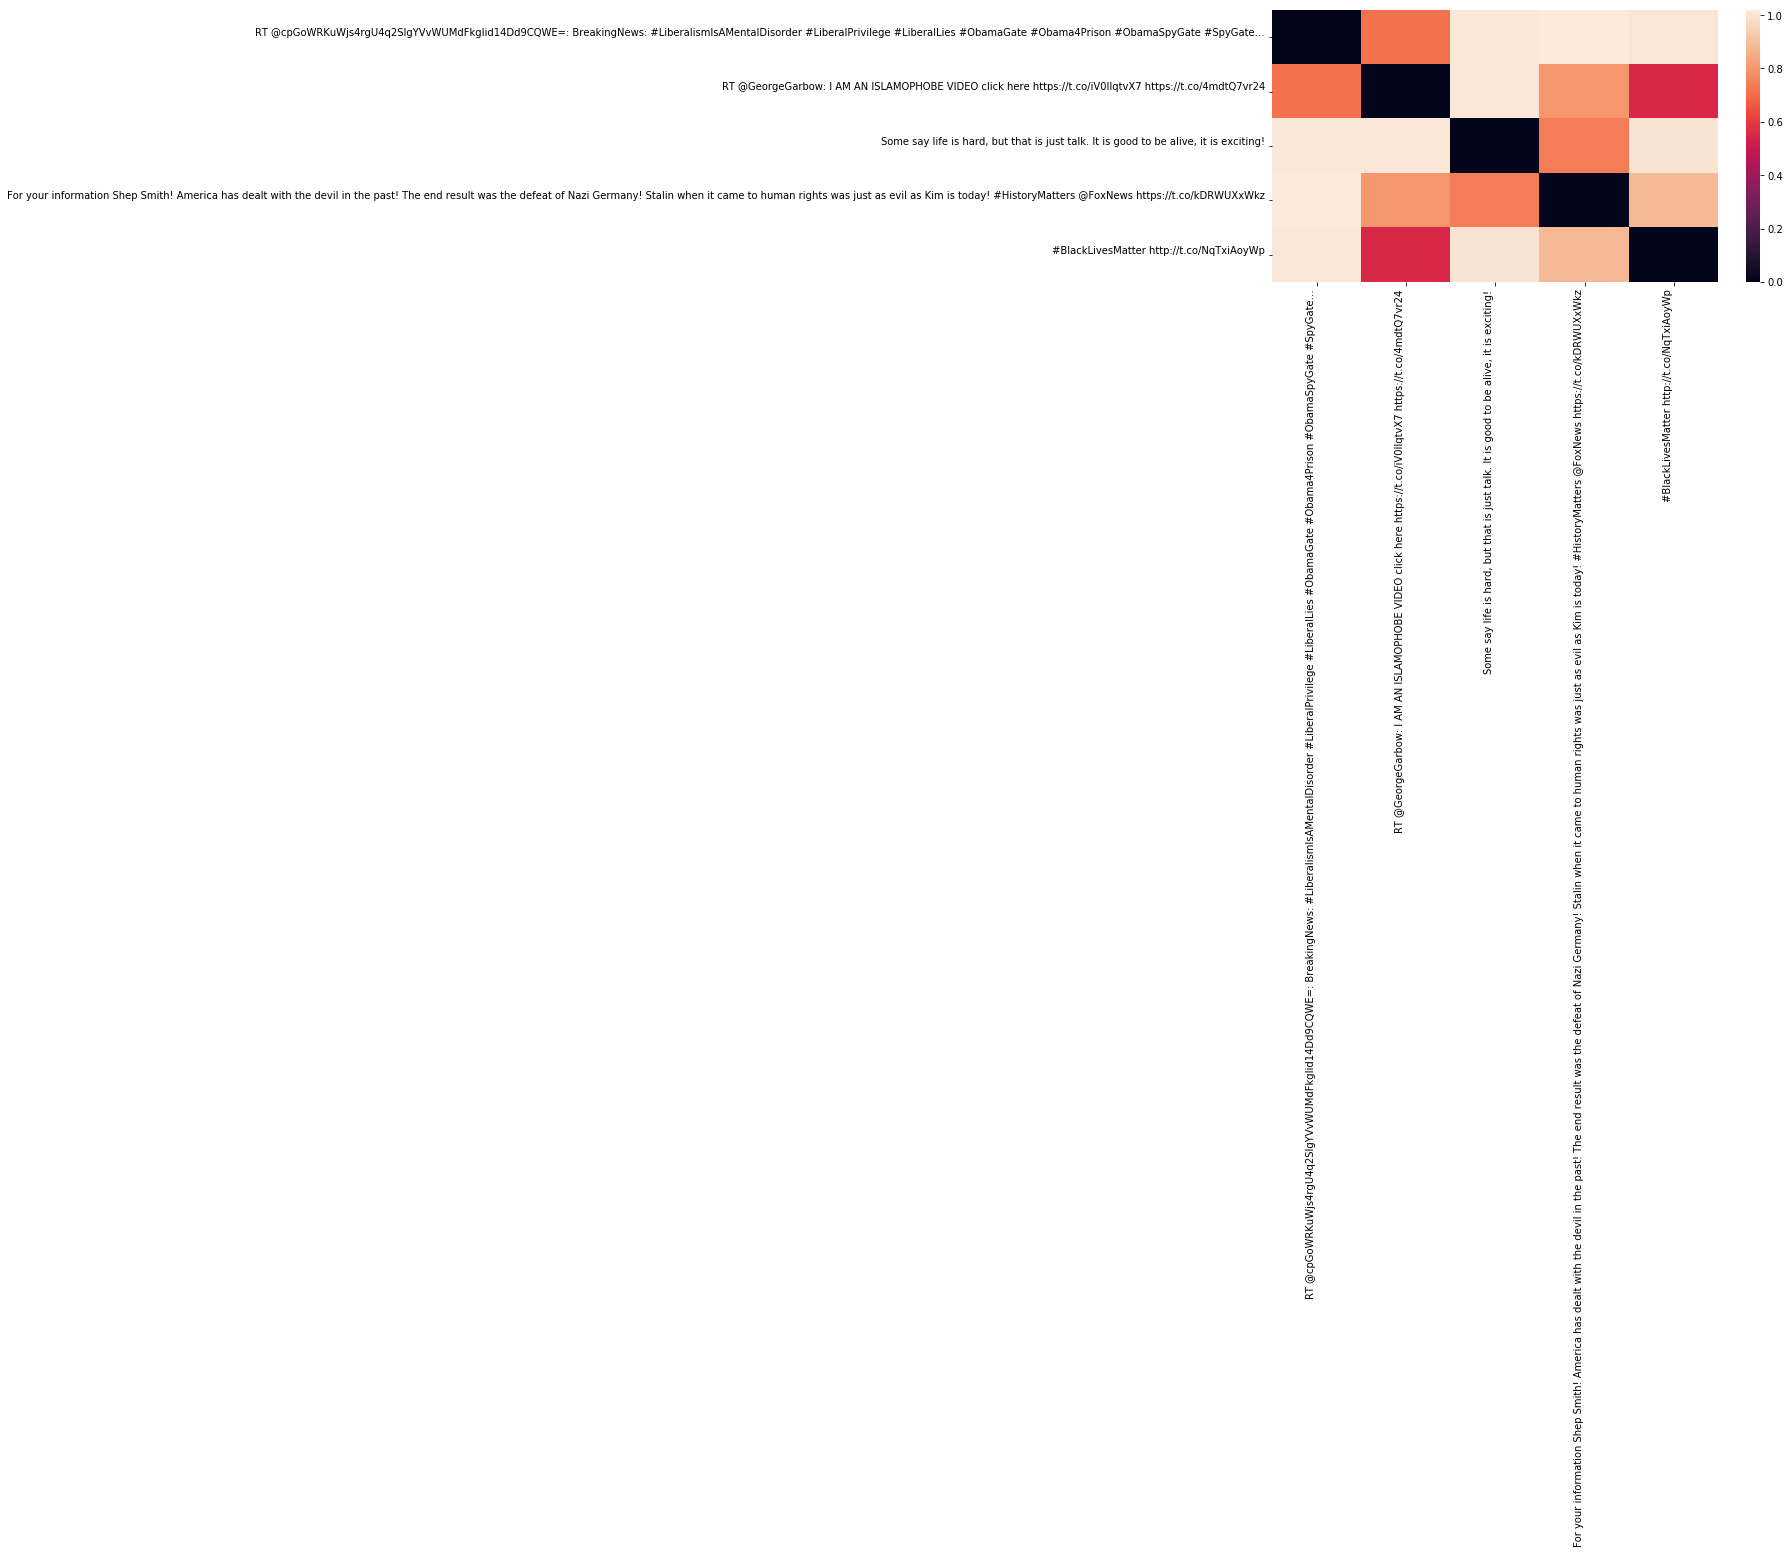

In [93]:
# Tweet-tweet distance SVD
rand = np.random.randint(0, high=len(tweets), size=5)
plt.figure(figsize=(10,5))
visualize_dist(tweet_SVD, tweets, rand)


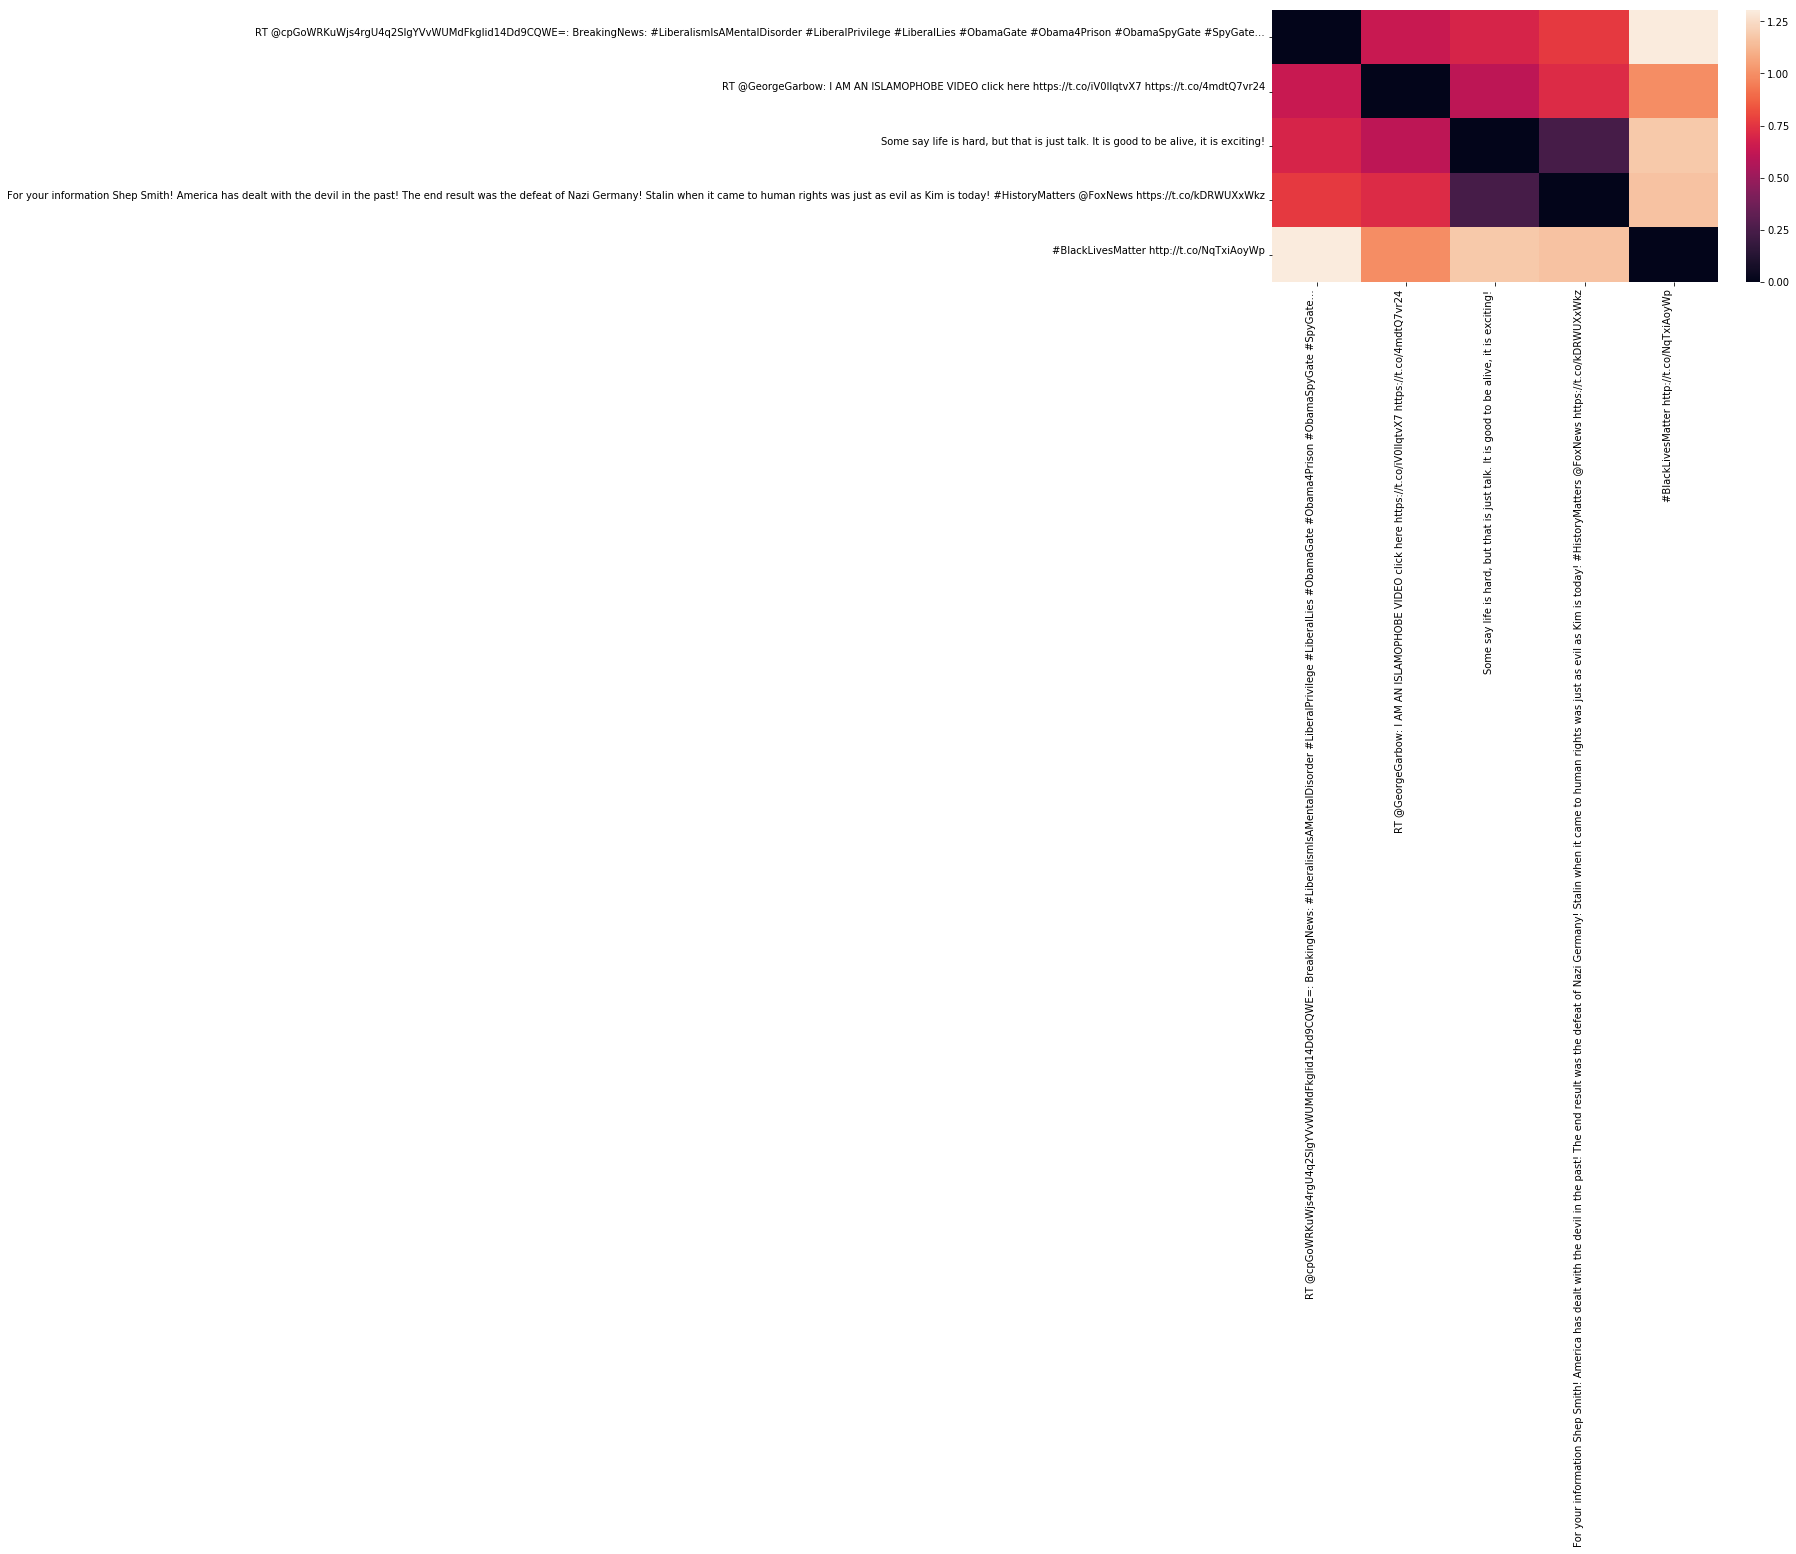

In [94]:
plt.figure(figsize=(10,5))
visualize_dist(word2vec_tweets, tweets, rand)

Word2Vec seems to rate the tweets as more similar compared to SVD here but the relative trends are similar.

In [ ]:
# More bonus!
# Use one of the following pre-embedded models and see if your yelp scores improve? 
# What about your Twitter explorations?

# https://github.com/RaRe-Technologies/gensim-data